# Network Analytics

## Visualising correlations between asset prices 

---------------------------


Original code & explanations atL https://nbviewer.org/github/julian-west/asset_price_correlations/blob/master/visualising_stock_correlations.ipynb

### Library imports


In [107]:
import csv
import datetime
import kaleido
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
import scipy 
import yfinance as yf
from pandas_datareader import data as pdr
from plotly.offline import init_notebook_mode


# plotly offline mode
init_notebook_mode(connected=True)

<IPython.core.display.Javascript object>

In [108]:
# import warnings
# # filte
# warnings.filterwarnings("ignore")

# notebook formatting
from IPython.display import HTML, display

<IPython.core.display.Javascript object>

### Fetch data


In [109]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [110]:
# Config

start   = datetime.datetime(2021, 1, 1)
end     = datetime.date.today()
symbols = [
    'VTI',  'VT',   'VPU',  'VNQ',  'QLTY',  'EWL', 
    'TFPN',
    'VIXY', 'VIXM', 
    'CCRV', 'CTA',  'GSG',  'KMLM', 
    'LTPZ', 'TLT',  'VTIP', 'VWOB',
    'CHFUSD=X', 'CADUSD=X', 'EURUSD=X', 'UUP'
    ]
etfDataFile   = 'data/daily_etf_prices.csv'
assetDataFile = 'data/daily_asset_prices.csv'

etfGraphJsonFile = "assets/plotly_etf_prices_network.json"
etfGraphImgFile  = "assets/stock_correlations_etf.html"

assetGraphJsonFile = "assets/plotly_etf_prices_network.json"
assetGraphImgFile  = "assets/stock_correlations_etf.html"

<IPython.core.display.Javascript object>

In [111]:
# Fetch fresh data & save it

yf.pdr_override()
etfData = pdr.get_data_yahoo(symbols, start, end)['Adj Close']
etfData.to_csv(etfDataFile)

etfData.head()


[*********************100%%**********************]  21 of 21 completed


,CADUSD=X,CCRV,CHFUSD=X,CTA,EURUSD=X,EWL,GSG,KMLM,LTPZ,QLTY,...,TLT,UUP,VIXM,VIXY,VNQ,VPU,VT,VTI,VTIP,VWOB
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,0.809723,NaN,1.113462,NaN,1.218027,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-04,0.786034,11.670424,1.132375,NaN,1.225070,42.539616,12.24,22.903774,77.639542,NaN,...,146.488876,22.604940,37.470001,301.000000,73.742645,121.847176,86.445679,183.422226,44.396408,70.646683
2021-01-05,0.782411,11.936722,1.134765,NaN,1.225160,42.850399,12.67,23.361538,77.203560,NaN,...,145.400940,22.474493,37.090000,289.600006,73.850334,121.929016,87.394173,184.903931,44.422470,70.672562
2021-01-06,0.788973,11.958136,1.138719,NaN,1.230027,42.662045,12.69,23.220819,76.192093,NaN,...,142.416138,22.446539,36.790001,287.799988,73.975983,125.067337,88.014000,186.567368,44.431156,70.241211
2021-01-07,0.789553,11.972411,1.138861,NaN,1.234111,42.680882,12.71,22.992373,75.721214,NaN,...,141.160843,22.576986,36.250000,270.200012,73.832390,123.493629,88.906166,189.559525,44.509335,70.232597


<IPython.core.display.Javascript object>

In [112]:
# read csv file
assetData = pd.read_csv("data/daily_asset_prices.csv", index_col="Date")

# show first five rows
assetData.head()

,Bonds Global,Commodities,DOW,Emerg Markets,EAFE,Emerg Markets Bonds,Pacifix ex Japan,Germany,Italy,Japan,...,Europe,Pacific,VXX,Materials,Energy,Finance,Tech,Utilities,ST Corp Bond,CHF
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-08,81.83,16.40,235.46,46.78,69.87,114.60,47.69,33.18,30.95,60.02,...,58.20,72.77,33.53,58.70,69.82,26.25,64.01,55.70,104.96,94.5100
2017-11-07,81.89,16.43,235.42,46.56,69.64,114.65,47.22,33.07,31.09,59.65,...,58.17,72.20,33.52,58.64,70.16,26.38,63.66,55.66,105.01,94.5400
2017-11-06,81.86,16.53,235.41,46.86,69.90,115.26,47.20,33.34,31.22,59.18,...,58.67,71.98,33.34,58.58,70.25,26.75,63.63,55.00,105.00,94.7500
2017-11-03,81.80,16.22,235.18,46.34,69.80,115.42,47.09,33.39,31.22,59.19,...,58.58,71.88,33.66,58.83,68.68,26.78,63.49,55.21,105.00,94.4400
2017-11-02,81.73,16.12,234.96,46.58,69.91,116.15,47.31,33.50,31.43,59.05,...,58.69,71.89,33.71,58.86,68.48,26.89,62.99,55.01,105.04,94.6299


<IPython.core.display.Javascript object>

## Calculate asset price correlations

#### Convert to log returns

Before calculating the correlation matrix, it is important to first normalise the dataset and convert the absolute asset prices into daily returns. In financial time-series it is common to make this transformation as investors are typically interested in returns on assets rather than their absolute prices. By normalising the data it allows us to compare the expected returns of two assets more easily. 


In [113]:
def log_returns(dataFrame):
    # create empty dataframe for log returns information
    logReturnsDf = pd.DataFrame()

    # calculate log returns of each asset
    # loop through each column in dataframe and and calculate the daily log returns
    # add log returns column to new a dataframe
    for col in dataFrame.columns:
        # dates are given in reverse order so need to set diff to -1.
        logReturnsDf[col] = np.log(dataFrame[col]).diff(-1)

    return logReturnsDf

<IPython.core.display.Javascript object>

In [114]:
assetReturns = log_returns(assetData)
assetReturns.head()

,Bonds Global,Commodities,DOW,Emerg Markets,EAFE,Emerg Markets Bonds,Pacifix ex Japan,Germany,Italy,Japan,...,Europe,Pacific,VXX,Materials,Energy,Finance,Tech,Utilities,ST Corp Bond,CHF
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-08,-0.000733,-0.001828,0.000170,0.004714,0.003297,-0.000436,0.009904,0.003321,-0.004513,0.006184,...,0.000516,0.007864,0.000298,0.001023,-0.004858,-0.004940,0.005483,0.000718,-0.000476,-0.000317
2017-11-07,0.000366,-0.006068,0.000042,-0.006423,-0.003727,-0.005306,0.000424,-0.008131,-0.004173,0.007911,...,-0.008559,0.003052,0.005384,0.001024,-0.001282,-0.013928,0.000471,0.011929,0.000095,-0.002219
2017-11-06,0.000733,0.018932,0.000977,0.011159,0.001432,-0.001387,0.002333,-0.001499,0.000000,-0.000169,...,0.001535,0.001390,-0.009552,-0.004259,0.022602,-0.001121,0.002203,-0.003811,0.000000,0.003277
2017-11-03,0.000856,0.006184,0.000936,-0.005166,-0.001575,-0.006305,-0.004661,-0.003289,-0.006704,0.002368,...,-0.001876,-0.000139,-0.001484,-0.000510,0.002916,-0.004099,0.007906,0.003629,-0.000381,-0.002009
2017-11-02,0.000979,0.006223,0.003283,0.001289,0.003008,0.002759,0.005723,0.004488,0.009591,0.001186,...,0.002559,0.002089,-0.011210,-0.007279,-0.002916,0.009341,0.000476,0.003642,0.000000,0.004553


<IPython.core.display.Javascript object>

In [115]:

etfReturns = log_returns(etfData)
etfReturns.head()

,CADUSD=X,CCRV,CHFUSD=X,CTA,EURUSD=X,EWL,GSG,KMLM,LTPZ,QLTY,...,TLT,UUP,VIXM,VIXY,VNQ,VPU,VT,VTI,VTIP,VWOB
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,0.029693,NaN,-0.016843,NaN,-0.005766,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-04,0.004619,-0.022562,-0.002108,NaN,-0.000074,-0.007279,-0.034528,-0.019789,0.005631,NaN,...,0.007454,0.005787,0.010193,0.038610,-0.001459,-0.000671,-0.010912,-0.008046,-0.000587,-0.000366
2021-01-05,-0.008352,-0.001792,-0.003478,NaN,-0.003965,0.004405,-0.001577,0.006042,0.013188,NaN,...,0.020742,0.001245,0.008121,0.006235,-0.001700,-0.025413,-0.007067,-0.008956,-0.000196,0.006122
2021-01-06,-0.000734,-0.001193,-0.000125,NaN,-0.003314,-0.000441,-0.001575,0.009887,0.006199,NaN,...,0.008853,-0.005795,0.014787,0.063103,0.001943,0.012663,-0.010086,-0.015911,-0.001758,0.000123
2021-01-07,0.001452,-0.005260,0.008031,NaN,0.005661,-0.003084,-0.014063,0.002459,0.010651,NaN,...,0.003233,-0.001650,0.000552,0.009669,-0.009677,-0.007193,-0.009043,-0.004830,0.000976,-0.000123


<IPython.core.display.Javascript object>

#### Calculate correlations matrix

To calculate the pairwise correlations between assets we can simply use the inbuilt pandas _corr()_ function.

In [116]:
# calculate correlation matrix using inbuilt pandas function
assetCorrMatrix = assetReturns.corr()

# show first five rows of the correlation matrix
assetCorrMatrix.head()

,Bonds Global,Commodities,DOW,Emerg Markets,EAFE,Emerg Markets Bonds,Pacifix ex Japan,Germany,Italy,Japan,...,Europe,Pacific,VXX,Materials,Energy,Finance,Tech,Utilities,ST Corp Bond,CHF
Bonds Global,1.000000,-0.086234,-0.279161,-0.069623,-0.177521,0.296679,-0.104739,-0.188547,-0.201014,-0.159231,...,-0.181249,-0.141707,0.222886,-0.220603,-0.198536,-0.420264,-0.197672,0.301774,0.598105,0.250142
Commodities,-0.086234,1.000000,0.305137,0.428909,0.369637,0.313791,0.400316,0.283711,0.331083,0.250509,...,0.367019,0.341089,-0.224835,0.429541,0.677430,0.257454,0.225463,0.089290,0.028872,0.042324
DOW,-0.279161,0.305137,1.000000,0.719260,0.793387,0.343817,0.688344,0.722882,0.666315,0.691672,...,0.765251,0.769604,-0.797538,0.817422,0.655544,0.874902,0.849271,0.395247,-0.042967,-0.172730
Emerg Markets,-0.069623,0.428909,0.719260,1.000000,0.796425,0.580454,0.815049,0.697222,0.660268,0.638955,...,0.763111,0.811155,-0.668680,0.674630,0.607172,0.606749,0.686458,0.365031,0.123624,-0.018461
EAFE,-0.177521,0.369637,0.793387,0.796425,1.000000,0.466883,0.790699,0.884385,0.830052,0.785198,...,0.949368,0.872972,-0.721559,0.720030,0.610561,0.711714,0.725415,0.352270,0.050121,0.021760


<IPython.core.display.Javascript object>

In [117]:
etfCorrMatrix = etfReturns.corr()
etfCorrMatrix.head()

,CADUSD=X,CCRV,CHFUSD=X,CTA,EURUSD=X,EWL,GSG,KMLM,LTPZ,QLTY,...,TLT,UUP,VIXM,VIXY,VNQ,VPU,VT,VTI,VTIP,VWOB
CADUSD=X,1.000000,0.114483,0.438334,-0.082785,0.532474,0.019426,0.090779,0.101489,-0.011733,-0.267322,...,-0.043294,-0.040967,0.035429,0.014816,0.023726,-0.015380,-0.011620,-0.003721,0.065728,-0.052651
CCRV,0.114483,1.000000,-0.008679,-0.042132,-0.029271,0.130030,0.922438,0.353770,0.088566,0.232833,...,-0.089041,-0.227297,-0.143919,-0.176108,0.146102,0.108791,0.232496,0.204913,0.346493,0.082449
CHFUSD=X,0.438334,-0.008679,1.000000,-0.120678,0.748820,-0.072077,-0.021022,0.004279,0.021096,-0.315778,...,0.056665,-0.010835,0.090160,0.073383,-0.019692,-0.040168,-0.069465,-0.061241,0.063713,-0.002335
CTA,-0.082785,-0.042132,-0.120678,1.000000,-0.068355,-0.257936,-0.028669,0.398636,-0.301469,-0.004084,...,-0.306351,0.407907,0.033726,0.052480,-0.267648,-0.220844,-0.220918,-0.190001,-0.405034,-0.344631
EURUSD=X,0.532474,-0.029271,0.748820,-0.068355,1.000000,-0.023464,-0.040753,0.011525,0.016984,-0.308750,...,0.045575,-0.017214,0.031541,0.018663,0.020377,-0.055373,-0.027181,-0.016381,0.063426,0.021701


<IPython.core.display.Javascript object>

In [118]:
# convert matrix to list of edges and rename the columns
def edges(corrMatrix):
    retEdges = corrMatrix.stack().reset_index()
    retEdges.columns = ["asset_1", "asset_2", "correlation"]

    # remove self correlations
    retEdges = retEdges.loc[retEdges["asset_1"] != retEdges["asset_2"]].copy()

    return retEdges


<IPython.core.display.Javascript object>

In [119]:
assetEdges = edges(assetCorrMatrix)
assetEdges.head()

,asset_1,asset_2,correlation
1,Bonds Global,Commodities,-0.086234
2,Bonds Global,DOW,-0.279161
3,Bonds Global,Emerg Markets,-0.069623
4,Bonds Global,EAFE,-0.177521
5,Bonds Global,Emerg Markets Bonds,0.296679


<IPython.core.display.Javascript object>

In [120]:
etfEdges = edges(etfCorrMatrix)
etfEdges.head()

,asset_1,asset_2,correlation
1,CADUSD=X,CCRV,0.114483
2,CADUSD=X,CHFUSD=X,0.438334
3,CADUSD=X,CTA,-0.082785
4,CADUSD=X,EURUSD=X,0.532474
5,CADUSD=X,EWL,0.019426


<IPython.core.display.Javascript object>

__Create graph from edge list__

Now that we have an edge list we need to feed that into the networkx library to create a graph. Note that this network is undirected as the correlation between assets is the same in both directions.

In [121]:
# create undirected graph with weights corresponding to the correlation magnitude
def undirected_graph(edges, threshold): 
    ##G0 = nx.from_pandas_edgelist(edges, "asset_1", "asset_2", edge_attr=["correlation"])
    ##return G0

    # 'winner takes all' method - set minium correlation threshold to remove some
    # edges from the diagram
    #threshold = 0.3 # 0.5

    # create a new graph from edge list
    Gx = nx.from_pandas_edgelist(edges, "asset_1", "asset_2", edge_attr=["correlation"])

    # list to store edges to remove
    remove = []
    # loop through edges in Gx and find correlations which are below the threshold
    for asset_1, asset_2 in Gx.edges():
        corr = Gx[asset_1][asset_2]["correlation"]
        # add to remove node list if abs(corr) < threshold
        if abs(corr) < threshold:
            remove.append((asset_1, asset_2))

    # remove edges contained in the remove list
    Gx.remove_edges_from(remove)
    print(str(len(remove)) + " edges removed")

    return Gx


<IPython.core.display.Javascript object>

In [122]:
etfG0 = undirected_graph(etfEdges, 0.3)
print(etfG0)

138 edges removed
Graph with 21 nodes and 72 edges


<IPython.core.display.Javascript object>

In [123]:
assetG0 = undirected_graph(assetEdges, 0.5)
print(assetG0)

530 edges removed
Graph with 39 nodes and 211 edges


<IPython.core.display.Javascript object>

##### Create colour, edge thickness and node size features

In [124]:
def assign_colour(correlation):
    if correlation <= 0:
        return "#ffa09b"  # red
    else:
        return "#9eccb7"  # green


def assign_thickness(correlation, benchmark_thickness=2, scaling_factor=3):
    return benchmark_thickness * abs(correlation) ** scaling_factor


def assign_node_size(degree, scaling_factor=50):
    return degree * scaling_factor


# assign colours to edges depending on positive or negative correlation
# assign edge thickness depending on magnitude of correlation
def edge_colours(Gx):
    colours = []
    for key, value in nx.get_edge_attributes(Gx, "correlation").items():
        colours.append(assign_colour(value))
    return colours

def edge_width(Gx):
    width = []
    for key, value in nx.get_edge_attributes(Gx, "correlation").items():
        width.append(assign_thickness(value))
    return width

# assign node size depending on number of connections (degree)
def node_size(Gx):
    sizes = []
    for key, value in dict(Gx.degree).items():
        sizes.append(assign_node_size(value))
    return sizes

<IPython.core.display.Javascript object>

##### Minimum spanning tree

[Kruskal's algorithm](https://en.wikipedia.org/wiki/Kruskal%27s_algorithm) is used to calculate the minimum spanning tree and is fairly intuitive. However, Networkx has an inbuilt function which calculates the minimum spanning tree for us. 

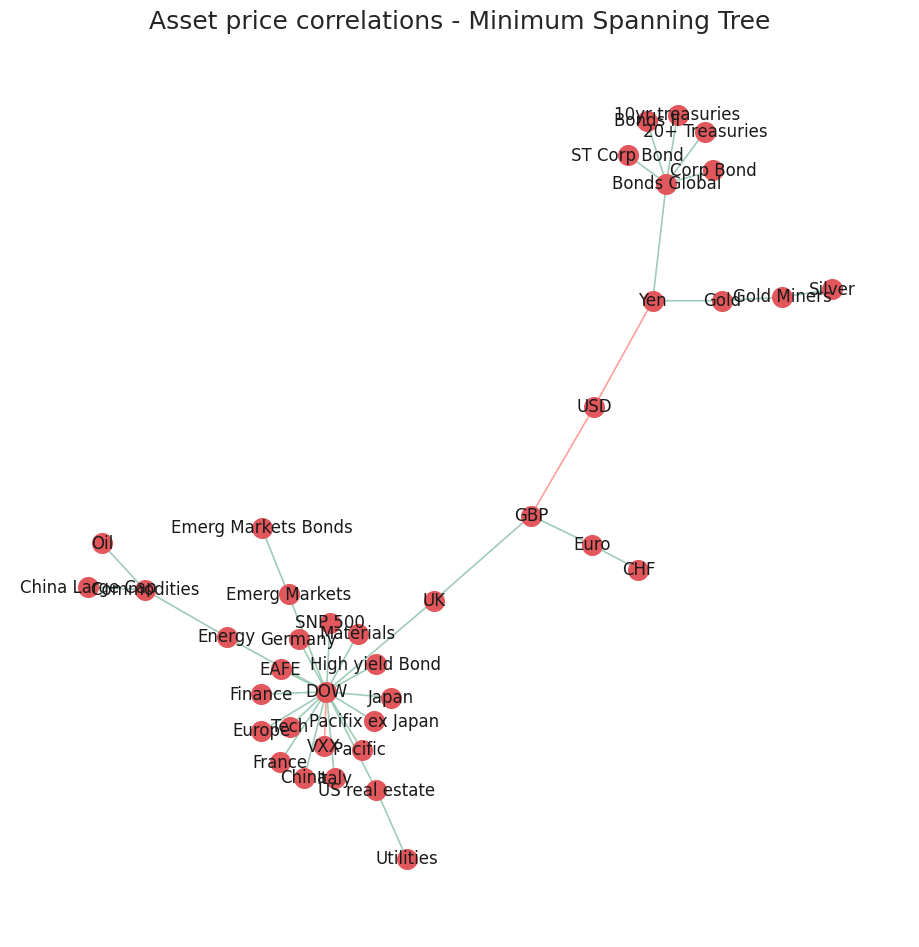

<IPython.core.display.Javascript object>

In [125]:
sns.set(rc={"figure.figsize": (9, 9)})
font_dict = {"fontsize": 18}

# create minimum spanning tree layout from Gx
# (after small correlations have been removed)
mst = nx.minimum_spanning_tree(assetG0)

edge_colours = []

# assign edge colours
for key, value in nx.get_edge_attributes(mst, "correlation").items():
    edge_colours.append(assign_colour(value))


# draw minimum spanning tree. Set node size and width to constant
nx.draw(
    mst,
    with_labels=True,
    pos=nx.fruchterman_reingold_layout(mst),
    node_size=200,
    node_color="#e1575c",
    edge_color=edge_colours,
    width=1.2,
)

# set title
plt.title("Asset price correlations - Minimum Spanning Tree", fontdict=font_dict)
plt.show()

##### Functions to get node information to populate tooltips

The following functions calculate the above quantities. It should be noted that Plotly tooltips are formatted using html. Therefore the input to the tooltip should be a string with the relevant html tags for any formatting that is required. 

In [126]:
def convert_rankings_to_string(ranking):
    """
    Concatenate list of nodes and correlations into a single html
    string (required format for the plotly tooltip)

    Inserts html "<br>" inbetween each item in order to add a new
    line in the tooltip
    """
    s = ""
    for r in ranking:
        s += r + "<br>"
    return s


def calculate_stats(returns):
    """calculate annualised returns and volatility for all ETFs

    Returns:
        tuple: Outputs the annualised volatility and returns as a list of
            floats (for use in assigning node colours and sizes) and also
            as a lists of formatted strings to be used in the tool tips.
    """
    #print(returns.head())

    # log returns are additive, 252 trading days
    annualized_returns = [ 
        np.mean(returns[col]) * 252 * 100 for col in list(returns.columns)
    ]

    annualized_volatility = [
        np.std(returns[col] * 100) * (252 ** 0.5) for col in list(returns.columns)
    ]

    # create string for tooltip
    annualized_volatility_2dp = [
        "Annualized Volatility: " "%.1f" % r + "%" for r in annualized_volatility
    ]
    annualized_returns_2dp = [
        "Annualized Returns: " "%.1f" % r + "%" for r in annualized_returns
    ]

    return (
        annualized_volatility,
        annualized_returns,
        annualized_volatility_2dp,
        annualized_returns_2dp,
    )


def get_top_and_bottom_three(corrMatrix):
    """
    get a list of the top 3 and bottom 3 most/least correlated assests
    for each node.

    Args:
        df (pd.DataFrame): pandas correlation matrix

    Returns:
        top_3_list (list): list of lists containing the top 3 correlations
            (name and value)
        bottom_3_list (list): list of lists containing the bottom three
            correlations (name and value)
    """

    top_3_list = []
    bottom_3_list = []

    for col in corrMatrix.columns:

        # exclude self correlation #reverse order of the list returned
        top_3 = list(np.argsort(abs(corrMatrix[col]))[-4:-1][::-1])
        # bottom 3 list is returned in correct order
        bottom_3 = list(np.argsort(abs(corrMatrix[col]))[:3])

        # get column index
        col_index = corrMatrix.columns.get_loc(col)

        # find values based on index locations
        top_3_values = [corrMatrix.index[x] + ": %.2f" % corrMatrix.iloc[x, col_index] for x in top_3]
        bottom_3_values = [
            corrMatrix.index[x] + ": %.2f" % corrMatrix.iloc[x, col_index] for x in bottom_3
        ]

        top_3_list.append(convert_rankings_to_string(top_3_values))
        bottom_3_list.append(convert_rankings_to_string(bottom_3_values))

    return top_3_list, bottom_3_list

<IPython.core.display.Javascript object>

In [127]:
def get_coordinates(G):
    """Returns the positions of nodes and edges in a format
    for Plotly to draw the network
    """
    # get list of node positions
    pos = nx.fruchterman_reingold_layout(mst)

    Xnodes = [pos[n][0] for n in mst.nodes()]
    Ynodes = [pos[n][1] for n in mst.nodes()]

    Xedges = []
    Yedges = []
    for e in mst.edges():
        # x coordinates of the nodes defining the edge e
        Xedges.extend([pos[e[0]][0], pos[e[1]][0], None])
        Yedges.extend([pos[e[0]][1], pos[e[1]][1], None])

    return Xnodes, Ynodes, Xedges, Yedges

<IPython.core.display.Javascript object>

To plot the network we define the scatter plot (tracer) and line plot (tracer_marker) series and define some cosmetic parameters which dictate the graph layout.

In [128]:
# Plot graph
def plot_graph(dataFrame, threshold):
    returns = log_returns(dataFrame)
    corrMatrix = returns.corr()
    edgs = edges(corrMatrix)
    Gx = undirected_graph(edgs, threshold)

    # create minimum spanning tree layout from Gx
    # (after small correlations have been removed)
    mst = nx.minimum_spanning_tree(Gx)

    # get statistics for tooltip

    # make list of node labels.
    node_label = list(mst.nodes())
    # calculate annualised returns, annualised volatility and round to 2dp
    annual_vol, annual_ret, annual_vol_2dp, annual_ret_2dp = calculate_stats(returns)
    # get top and bottom 3 correlations for each node
    top_3_corrs, bottom_3_corrs = get_top_and_bottom_three(corrMatrix)


    # create tooltip string by concatenating statistics
    description = [
        f"<b>{node}</b>"
        + "<br>"
        + annual_ret_2dp[index]
        + "<br>"
        + annual_vol_2dp[index]
        + "<br><br>Strongest correlations with: "
        + "<br>"
        + top_3_corrs[index]
        + "<br>Weakest correlations with: "
        "<br>" + bottom_3_corrs[index]
        for index, node in enumerate(node_label)
    ]

    # get coordinates for nodes and edges
    Xnodes, Ynodes, Xedges, Yedges = get_coordinates(mst)

    # assign node colour depending on positive or negative annualised returns
    node_colour = [assign_colour(i) for i in annual_ret]

    # assign node size based on annualised returns size (scaled by a factor)
    node_size = [abs(x) ** 0.5 * 5 for x in annual_ret]

    # edges
    tracer = go.Scatter(
        x=Xedges,
        y=Yedges,
        mode="lines",
        line=dict(color="#DCDCDC", width=1),
        hoverinfo="none",
        showlegend=False,
    )


    # nodes
    tracer_marker = go.Scatter(
        x=Xnodes,
        y=Ynodes,
        mode="markers+text",
        textposition="top center",
        marker=dict(size=node_size, line=dict(width=1), color=node_colour),
        hoverinfo="text",
        hovertext=description,
        text=node_label,
        textfont=dict(size=7),
        showlegend=False,
    )


    axis_style = dict(
        title="",
        titlefont=dict(size=20),
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks="",
        showticklabels=False,
    )


    layout = dict(
        title="Plotly - interactive minimum spanning tree",
        width=800,
        height=800,
        autosize=False,
        showlegend=False,
        xaxis=axis_style,
        yaxis=axis_style,
        hovermode="closest",
        plot_bgcolor="#fff",
    )


    fig = go.Figure()
    fig.add_trace(tracer)
    fig.add_trace(tracer_marker)
    fig.update_layout(layout)

    fig.show()

    display(
        HTML(
            """
            <p>Node sizes are proportional to the size of
            annualised returns.<br>Node colours signify positive
            or negative returns since beginning of the timeframe.</p>
            """
        )
    )

    return fig


<IPython.core.display.Javascript object>

In [134]:
figEtf = plot_graph(etfData, 0.3)

#TODO ?

# Save interactive vis to json
figEtf.write_json(etfGraphJsonFile)
#figEtf.write_image("assets/stock_correlations2.png", format='png')
#figEtf.write_image("assets/stock_correlations2.svg", format='svg')
#figEtf.write_image("assets/stock_correlations2.webp", format='webp')

figEtf2 = px.scatter()
figEtf2.write_html(etfGraphImgFile)

138 edges removed


<IPython.core.display.Javascript object>

In [133]:
figAsset = plot_graph(assetData, 0.5)

figAsset.write_json(assetGraphJsonFile)
figAsset2 = px.scatter()
figAsset2.write_html(assetGraphImgFile)

530 edges removed


<IPython.core.display.Javascript object>